In [2]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST Dataset

In [51]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X,y=mnist["data"],mnist["target"]
print(X.shape) #no. of images and #no. of features in each image. Here, 784 'cuz 784=28*28
print(y.shape)

(70000, 784)
(70000,)


Saving figure some_digit_plot


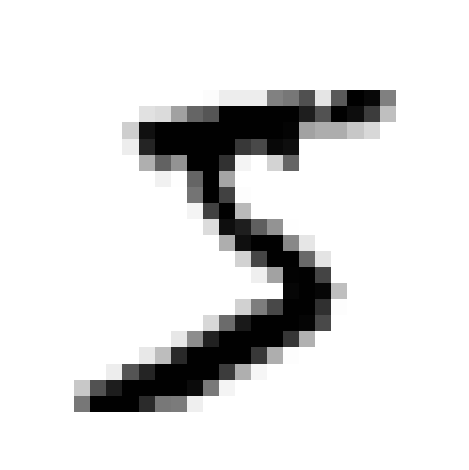

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit=X.iloc[0]
some_digit_image = some_digit.values.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [5]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [6]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure Some more examples


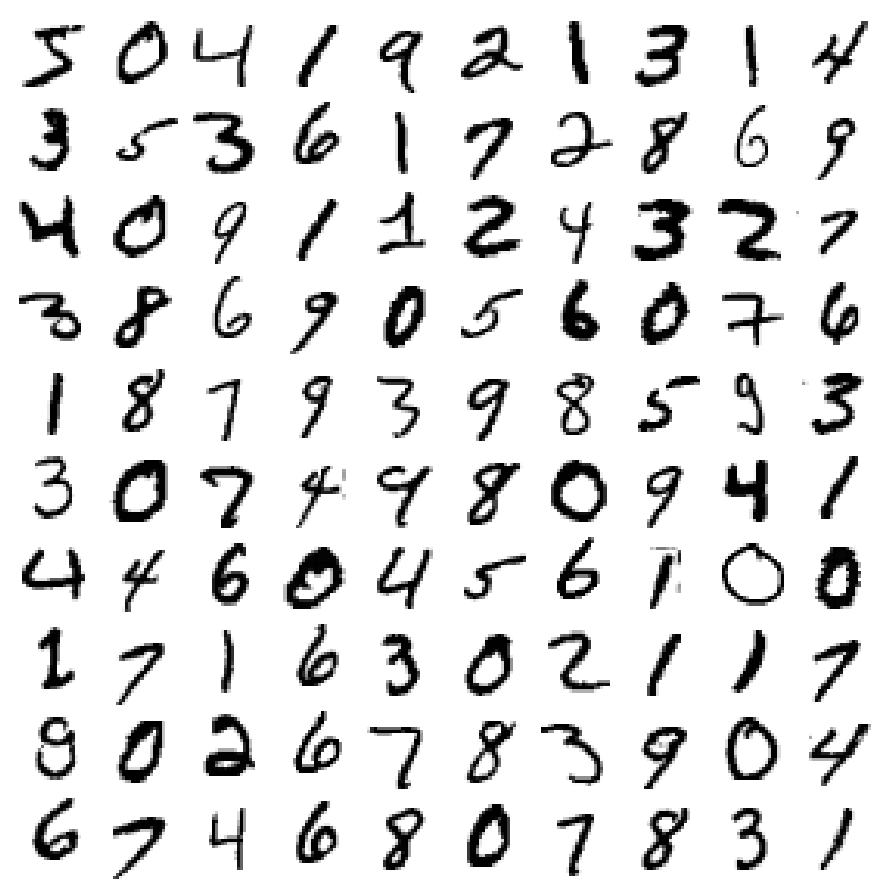

In [7]:
plt.figure(figsize=(9,9))
examples = X[:100]
plot_digits(examples, images_per_row=10)
save_fig("Some more examples")
plt.show()

In [8]:
y[0]

'5'

In [9]:
import numpy as np
y=y.astype(np.uint8) #casting y as an integer

In [10]:
X_train, X_test, y_train, y_test=X[:60000],X[60000:],y[:60000],y[60000:] #splitting the dataset

## Training a Binary Classifier

In [11]:
#5-detector (binary classifier)
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5) 

SGDClassifier(random_state=42)

In [13]:
import pandas as pd
some_digit_df = pd.DataFrame([some_digit], columns=X_train.columns)
sgd_clf.predict(some_digit_df) #5-detector model test on some_digit

array([ True])

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [15]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1),dtype=bool)

never_5_clf=Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

## Confusion Matrix

In [16]:
#Confusion matrix evaluation
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) #k-fold-cross-validation predictions
cm = confusion_matrix(y_train_5, y_train_pred) 
cm
#[[TN,FP],
# [FN,TP]]

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

To better understand confusion matrix `confusion_matrix(y_train_5, y_train_5)`,
the first row (considers the 'non-5' images) is the `negative` class - first column `true negative(TN)`, second column `false positives(FP)`; while,
the second row (considers the '5' images) is the `positive` class - first column `false negatives(FN)`, second column `true positives(TP)`

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [19]:
# Precision = TP/(TP+FP)
cm[1,1]/(cm[1,1]+cm[0,1])

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [21]:
# Recall = TP/(TP+FN)
cm[1,1]/(cm[1,1]+cm[1,0])

0.6511713705958311

In [22]:
f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [23]:
# F1 = 2/(1/precision + 1/recall) = TP/(TP + (FN+FP)/2)
cm[1,1]/(cm[1,1]+(cm[1,0]+cm[0,1])/2)

0.7325171197343847

## Precision/Recall Trade-off

In [24]:
y_scores = sgd_clf.decision_function(some_digit_df)
y_scores

array([2164.22030239])

In [25]:
threshold = 1000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [26]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

Saving figure precision_recall_vs_threshold_plot


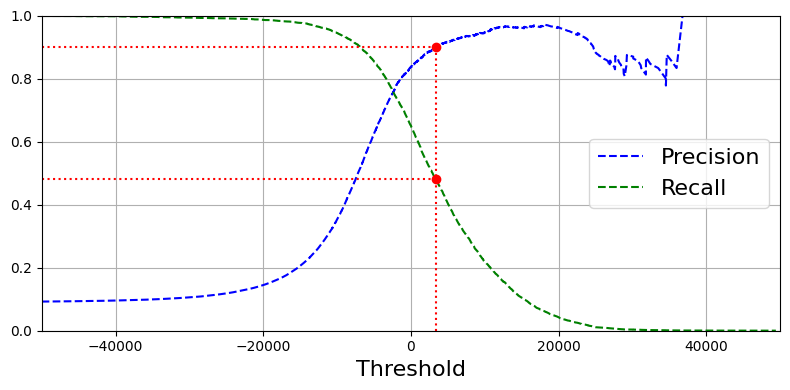

In [28]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             

    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
save_fig("precision_recall_vs_threshold_plot")                                              
plt.show()

Saving figure precision_vs_recall_plot


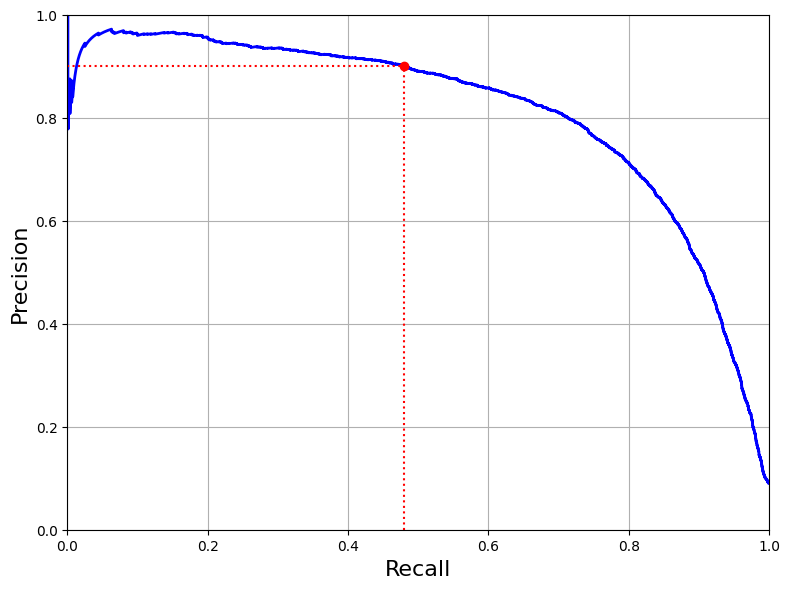

In [29]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [30]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [31]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


## The ROC Curve

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


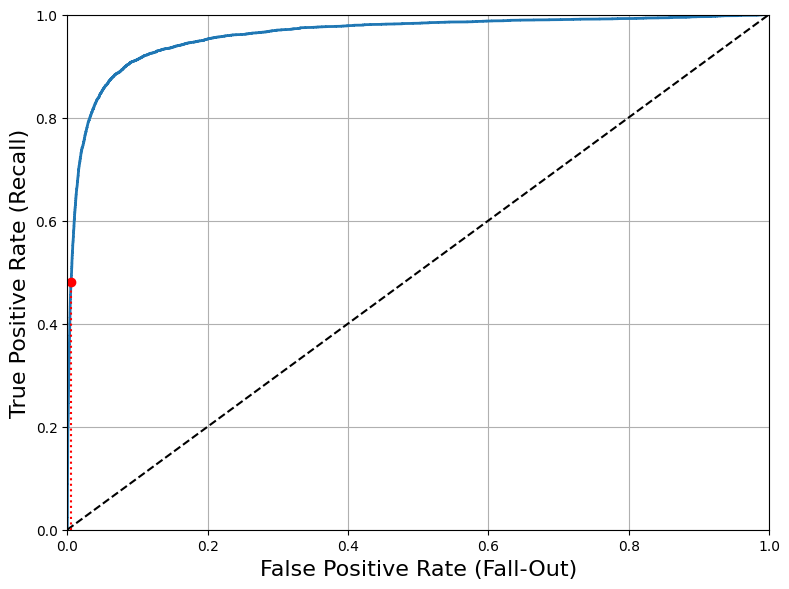

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #dashed diagonal
    plt.xlabel("False Positive Rate (Fall-Out)", fontsize=16)
    plt.ylabel("True Positive Rate (Recall)", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
save_fig("roc_curve_plot")
plt.show()

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### Using RandomForestClassifier

In [36]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method ="predict_proba")

In [37]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

Saving figure Random forest vs SGD


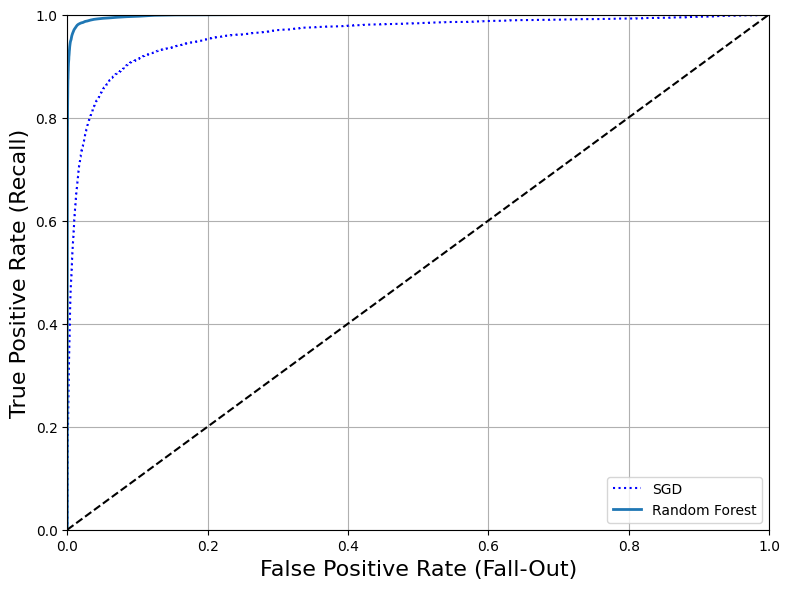

In [38]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
save_fig("Random forest vs SGD")
plt.show()

In [39]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass classification

### SVC Classifier

In [41]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict(some_digit_df)

array([5], dtype=uint8)

In [42]:
some_digit_scores = svm_clf.decision_function(some_digit_df)
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [43]:
np.argmax(some_digit_scores)

5

In [44]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

### OneVsRest Classifier

In [45]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict(some_digit_df)

array([5], dtype=uint8)

### SGD Classifier

In [46]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict(some_digit_df)

array([3], dtype=uint8)

In [47]:
sgd_clf.decision_function(some_digit_df)

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [48]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

In [53]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx= confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

Saving figure confusion_matrix_plot


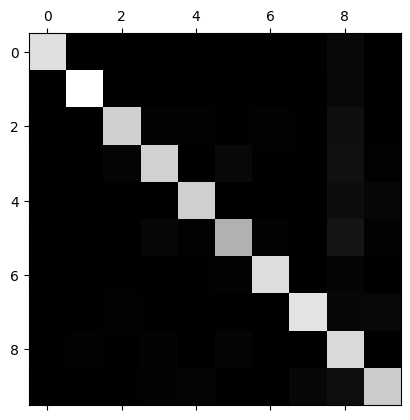

In [54]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [55]:
row_sums = conf_mx.sum(axis=1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


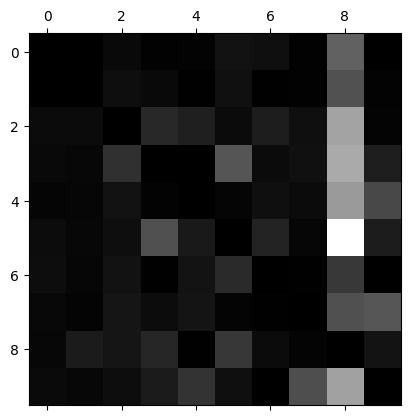

In [56]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

Saving figure error_analysis_digits_plot


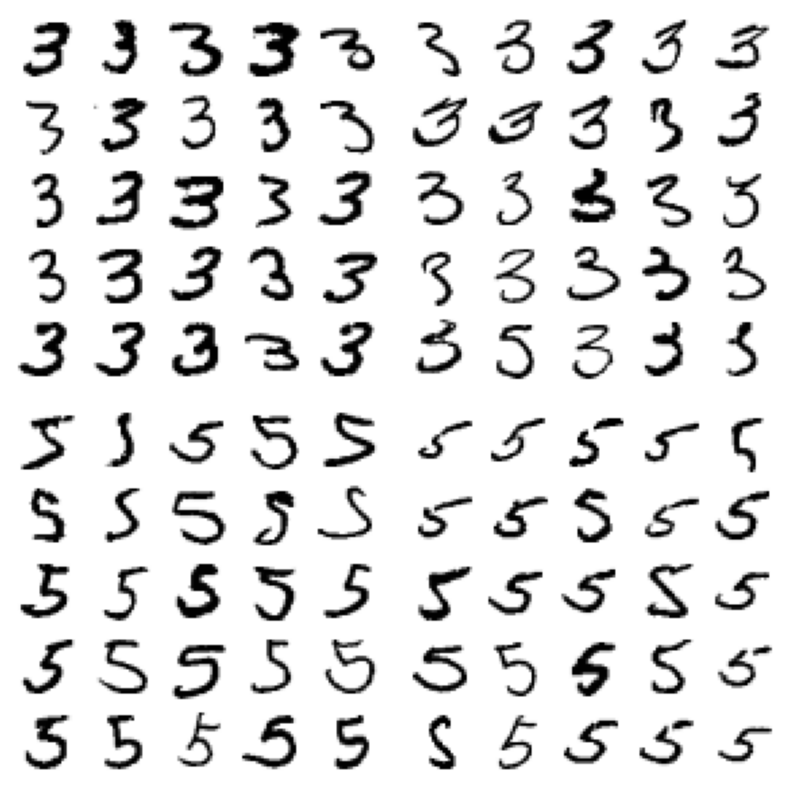

In [57]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

## Multilabel Classification

In [58]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [59]:
knn_clf.predict(some_digit_df)

array([[False,  True]])

In [60]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average = "macro")

0.9764102655606048

## Multioutput Classification

In [61]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


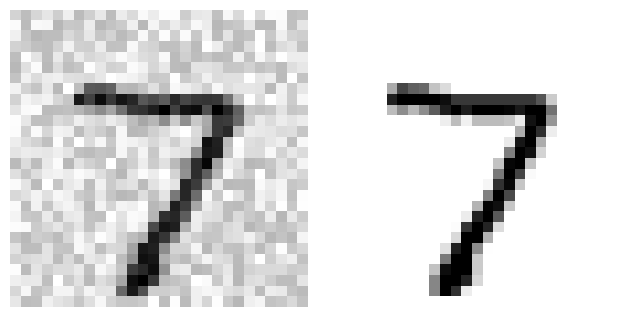

In [62]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod.iloc[some_index].to_numpy())
plt.subplot(122); plot_digit(y_test_mod.iloc[some_index].to_numpy())
save_fig("noisy_digit_example_plot")
plt.show()

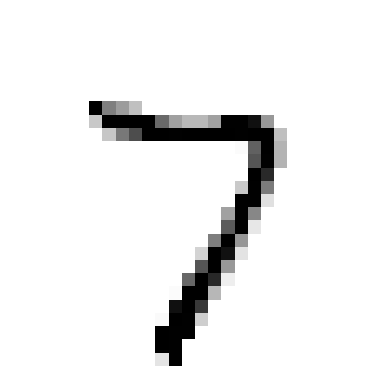

In [63]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict(X_test_mod.iloc[[some_index]])
plot_digit(clean_digit.reshape(28, 28))

# Exercises

## 1. MNIST dataset with over 97% accuracy

In [64]:
from sklearn.model_selection import GridSearchCV

param_grid =[{"weights": ["uniform", "distance"], "n_neighbors": [3, 4, 5]}]
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv = 5, verbose = 3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.972 total time=  38.5s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.971 total time=  49.8s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  33.5s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  28.3s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.970 total time= 1.1min
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  35.5s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  30.7s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  26.8s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  24.8s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.971 total time=  24.0s
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.969 total time=  28.2s
[CV 2/5] END ....n_neighbors=4, weights=uniform;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [65]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [66]:
grid_search.best_score_

0.9716166666666666

In [67]:
from sklearn.metrics import accuracy_score
y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

## 2. Data Augmentation

In [70]:
from scipy.ndimage import shift

def shift_image(image, dx, dy):
    image = image.reshape((28,28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

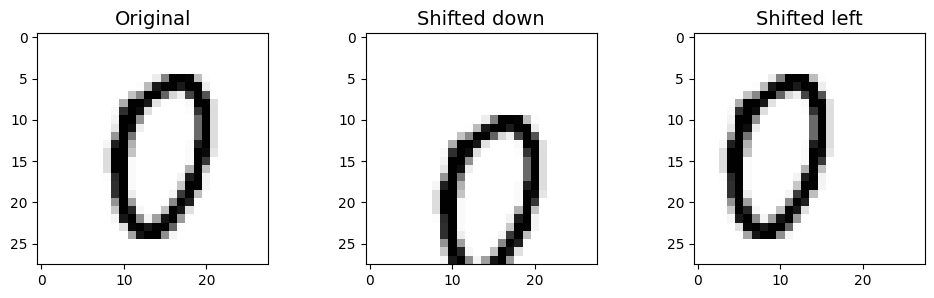

In [71]:
image = X_train.iloc[1000].to_numpy()
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [72]:
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()

X_train_augmented = [image for image in X_train_np]
y_train_augmented = [label for label in y_train_np]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train_np, y_train_np):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [73]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [68]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [74]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [76]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

C:\Python310\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


0.9763

## Saving trained model

In [77]:
import joblib
joblib.dump(knn_clf, "mnist_sklearn_model.pkl")

['mnist_sklearn_model.pkl']